# 2D Bayesian Full Waveform Inversion (FWI)

In this tutorial, we show 2D FWI results obtained using GeoPVI. The code example can be found in [](`GeoPVI/examples/fwi2d`) and in the user manual in `GeoPVI/doc`. In ths notebook, we reproduce/display the inversion results used in our papers ([Zhao and Curtis, 2024a](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023JB027789), [Zhao and Curtis, 2024b](https://essopenarchive.org/doi/full/10.22541/essoar.171691139.96106369), and [Zhao and Curtis, 2024c](https://arxiv.org/abs/2406.04072)).

We will consider **ADVI**, **PSVI**, and **BVI**. However, normalising flows require training of nerual networks whose size depends on the dimensionality (number of unknown parameters) of the FWI problem, and are therefore expensive to perform (in terms of both memory requirement and computational cost).

## Import libraries

In [31]:
import numpy as np
import torch
import scipy.sparse as sparse
import geopvi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

In [2]:
torch.set_default_dtype(torch.float64)

## Define necessary functions

In [4]:
def cons_2_real(x, lower, upper):
    z = np.log(x - lower) - np.log(upper - x)
    return z

def real_2_cons(x, lower, upper):
    z = lower + (upper - lower) / (1 + np.exp(-x))
    return z

def real_const(x, lower, upper):
    z = lower + (upper - lower) / (1 + np.exp(-x))
    log_det = (np.log(upper - lower) - x - 2 * np.log(1 + np.exp(-x)))
    return z, log_det

def const_real(x, lower, upper):
    z = np.log(x - lower) - np.log(upper - x)
    log_det = np.log(1 / (x - lower) + 1 / (upper - x))
    return z, log_det

The following functions are defined to plot the inversion results.

In [5]:
def marginal_2d(sample, dvel, dim = 50):
    marginal = np.zeros([dim, dvel.size])
    for i in range(dim):
        sample_i = sample[:,i]
        tmp = (sample_i < dvel[:,None]).mean(axis = 1)
        tmp[1:] = np.diff(tmp)
        marginal[i] = tmp
        
    return marginal / (dvel[1] - dvel[0])

In [6]:
def extend_trace(sample, vel_ext, water_layer):
    sample_new = np.full((sample.shape[0], nz), vel_ext)
    sample_new[:,water_layer:] = sample
    return sample_new

In [7]:
def extend_model(x, vel_ext, mask, vel_true):
    mean = np.full(mask.shape, vel_ext)
    std = np.zeros(mask.shape)
    error = np.zeros(mask.shape)
    mean[mask] = x.mean(axis = 0)
    std[mask] = x.std(axis = 0)
    error[mask] = np.abs(mean[mask] - vel_true[mask]) / std[mask]
    return mean, std, error

## Define FWI parameters

In [1]:
geopvi_path = '/home/GeoPVI/'

In [9]:
water_layer = 10
nx = 250
nz = 110
nr = 10
nt = 2001
ns = 12
dz = 0.02
ndim = nx * (nz - water_layer)
vel_water = 1950.

#### Define a mask denoting which parameters are fixed during inversion (within the water layer)

In [15]:
mask_inv = np.full([nz, nx], True)
mask_inv[:water_layer] = False

In [11]:
sourcex = np.arange(0.3, 5, 0.4)
sourcez = np.full(sourcex.shape, 0.02)
receiverx = np.arange(0,5,0.02)
receiverz = np.full(receiverx.shape, 0.18)

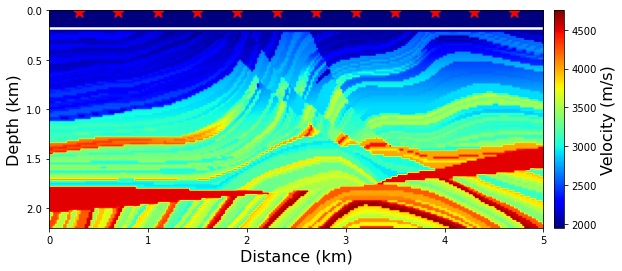

In [16]:
vel_true = np.loadtxt(geopvi_path + 'examples/fwi2d/input/vel_110_250.txt')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (11, 4))
im = ax.imshow(vel_true, cmap = 'jet', clim = (1950, 4750), extent=[0,5,2.2, 0])
    
ax.set_ylabel('Depth (km)', fontsize=16)
ax.set_xlabel('Distance (km)', fontsize=16)
ax.set_yticks([0, 0.5, 1, 1.5, 2.0])
ax.plot(receiverx, receiverz, 'w', linewidth = 2.5)
ax.scatter(sourcex, sourcez, s= 150, color= 'r' ,marker='*')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="2%",pad=0.15)
cbar = plt.colorbar(im, cax = cax)
cbar.set_label('Velocity (m/s)', fontsize=16)

plt.show()

#### Load observed waveform data

In [18]:
data_obs = np.load(geopvi_path + 'examples/fwi2d/input/waveform.npy')
data = data_obs.reshape(ns,nt,nx).transpose(1,0,2).reshape(nt,-1)

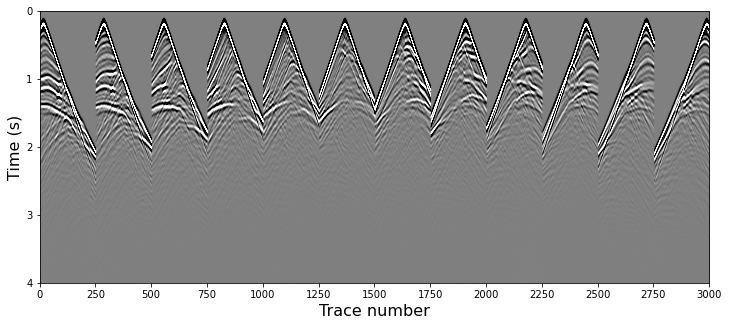

In [19]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot()
ax.imshow(data, cmap = 'gray', clim = (-1,1), extent=[0,3000,4, 0])
ax.set_aspect('auto')
ax.set_ylabel('Time (s)', fontsize=16)
ax.set_xlabel('Trace number', fontsize=16)
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xticks(np.arange(0,3001,250))

plt.show()

#### Load Uniform prior distribution

In [25]:
prior_bounds = np.loadtxt(geopvi_path + 'examples/fwi2d/input/prior.txt')
lower_bound = prior_bounds[water_layer:,0].astype(np.float64)
upper_bound = prior_bounds[water_layer:,1].astype(np.float64)
lower = np.broadcast_to(lower_bound[:,None],((nz - water_layer),nx)).flatten()
upper = np.broadcast_to(upper_bound[:,None],((nz - water_layer),nx)).flatten()

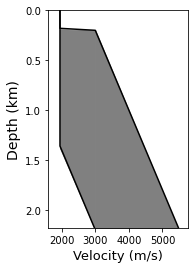

In [26]:
depth = np.arange(nz)

plt.figure(figsize = (2.5,4))
plt.plot(prior_bounds[:,0], depth*0.02, color = 'black')
plt.plot(prior_bounds[:,1], depth*0.02, color = 'black')
plt.fill_between(np.linspace(prior_bounds.min(), 3000, 100), np.linspace(0.190, 0.20, 100), np.linspace(1.38, 2.2, 100), color = 'grey')
plt.fill_between(np.linspace(3000, prior_bounds.max(), 69), np.linspace(0.2, 2.2, 69), np.full((69,), 2.2), color = 'grey')
plt.ylabel('Depth (km)', fontsize=14)
plt.xlabel('Velocity (m/s)', fontsize=13)
plt.yticks([0, 0.5, 1, 1.5, 2.0])
plt.xticks([2000, 3000, 4000, 5000])
plt.xlim(1600,5750)
plt.ylim(0,2.18)
plt.gca().invert_yaxis()

plt.show()

## Load inversion results

### epsilons: samples from base distribution (Standard Normal in this case)

In [27]:
nsample = 5000
ndim = nx * (nz - water_layer)
epsilons = np.random.normal(size = (nsample, ndim))

### Mean field ADVI

For mean field ADVI, variational parameters include $\mu$ and $\sigma$, corresponding to the mean and standard deviation vectors for the Gaussian distribution.

In [29]:
param = np.load(geopvi_path + 'examples/fwi2d/output/Linear_diagonal_parameter.npy')

mus = param[:ndim]
sigmas = param[ndim:]

theta = mus + epsilons * sigmas
advi = real_2_cons(theta, lower, upper)

### PSVI: in this test, the correlation kernel size is 5*5 in this example

FIrst, given the optimised variational parameters, construct a sparse matrix L using scipy.sparse.

Then, posterior samples can be obtained by $\theta = \mu + \mathbf{L}\epsilon$, followed by a real_2_cons transform.

In [32]:
param = np.load(geopvi_path + 'examples/fwi2d/output/Linear_structured_parameter.npy')

mus = param[:ndim]
sigmas = param[ndim:2*ndim]
diags = param[1*ndim:].reshape(-1, ndim)
print(diags.shape)

if diags.shape[0] > 1:
    offset = (diags == 0).sum(axis = 1)
    L = sparse.diags(diags, -offset, shape = (ndim, ndim))
if diags.shape[0] > 1:
    print('PSVI')
    theta = mus + (L @ epsilons.T).T
else:
    print('ADVI')
    theta = mus + epsilons * sigmas

psvi = real_2_cons(theta, lower, upper)

(13, 25000)
PSVI


### Boosting variational inference (BVI)

Considering the dimensionality of this FWI problem, we employ a diagonal Gaussian component distribution as mentioned in [Zhao and Curtis, 2024a](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023JB027789).

Below load posterior samples from BVI directly. Alternatively, you could sample the obtained mixture of Gaussian distributions to get these samples.

In [52]:
bvi = np.load(geopvi_path + f'examples/fwi2d/output/bvi_samples.npy')

## Display inversion results

### 1. Mean, standard deviation and relative error maps

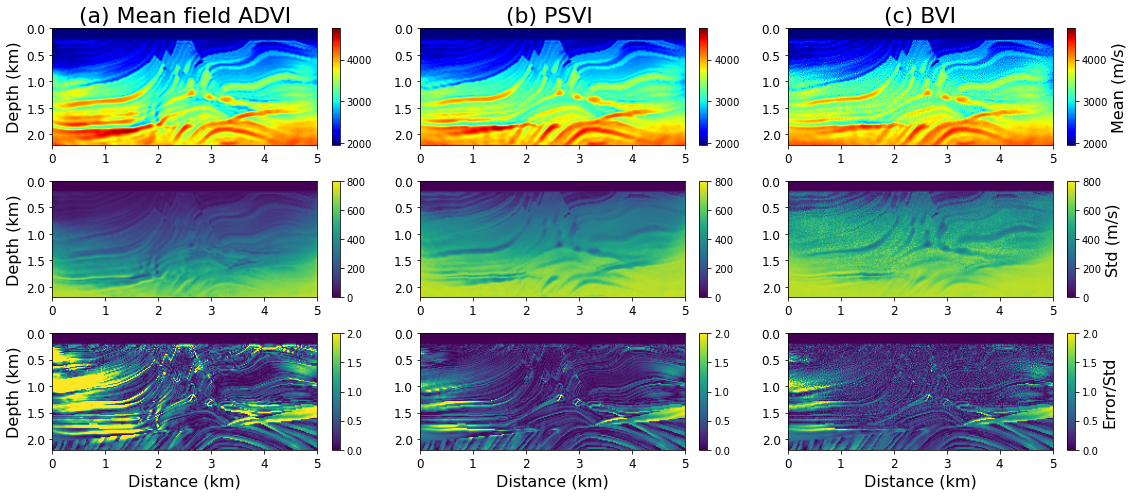

In [61]:
nrow = 3
ncol = 3

samples = [advi, psvi, bvi]
title = ['(a) Mean field ADVI', '(b) PSVI ', '(c) BVI']

fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = (16, 7))

for j in range(ncol):
    mean, std, error = extend_model(samples[j], vel_water, mask_inv, vel_true)
    for i in range(nrow):
        if i == 0:
            im = ax[i, j].imshow(mean, cmap = 'jet', clim = (1950, 4750), extent=[0,5,2.2, 0])
            ax[i,j].set_title(title[j], fontsize = 22)
            string = 'Mean (m/s)'
        elif i == 1:
            im = ax[i, j].imshow(std, clim = (0, 800), extent=[0,5,2.2, 0])
            string = 'Std (m/s)'
        elif i == 2:
            im = ax[i, j].imshow(error, clim = (0, 2.), extent=[0,5,2.2, 0])
            string = 'Error/Std'
            
        if j == 0:
            ax[i,j].set_ylabel('Depth (km)', fontsize=16)
        ax[i,j].set_yticks([0, 0.5, 1, 1.5, 2.0])
        ax[i,j].tick_params(axis="y", labelsize=12)
        ax[i,j].tick_params(axis="x", labelsize=12)
        
        divider = make_axes_locatable(ax[i,j])
        cax = divider.append_axes("right",size="3%",pad=0.2)
        cbar = plt.colorbar(im, cax = cax)
        if j == ncol - 1:
            cbar.set_label(string, fontsize=16)
            
        if i == nrow - 1:
            ax[i,j].set_xlabel('Distance (km)', fontsize=16)

fig.subplots_adjust(wspace=0.05, hspace=0.2)
plt.tight_layout()
plt.show()

### 2. Posterior marginal pdf's

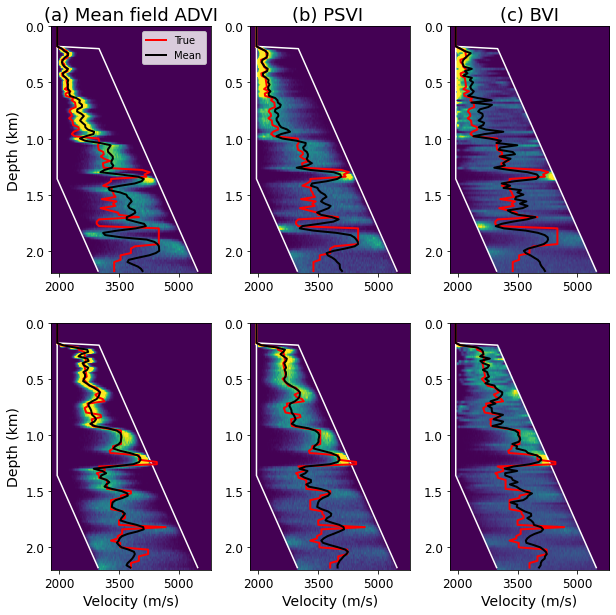

In [59]:
nrow = 2
ncol = 3

dx = np.arange(0,1,0.001)

samples = [advi, psvi, bvi]
title = ['(a) Mean field ADVI', '(b) PSVI ', '(c) BVI']
logs = [50, 130]

fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = (10, 10))

for j in range(ncol):
    for i in range(nrow):
        trace = logs[i]
        sample_trace = samples[j].reshape([-1,(nz - water_layer),nx])[:,:,trace]
        sample_full = extend_trace(sample_trace, vel_water, water_layer)
        dvel = 1800 + (5800 - 1800) * dx
        marginal_trace = marginal_2d(sample_full, dvel, nz)
        im = ax[i, j].imshow(marginal_trace, extent = [1800,5800,2.2,0], aspect = 'auto', clim = [0,0.002])
        if i == 0:
            ax[i,j].set_title(title[j], fontsize = 18)
        ax[i, j].plot(prior_bounds[:,0], np.arange((nz))*dz, color = 'white')
        ax[i, j].plot(prior_bounds[:,1], np.arange((nz))*dz, color = 'white')
        ax[i, j].plot(vel_true[:,trace], np.arange(0, (nz))*dz, color = 'red', linewidth = 2, label = 'True')
        ax[i, j].plot(sample_full.mean(axis = 0), np.arange(0, (nz))*dz, color = 'black', linewidth = 2, label = 'Mean')
        if i == 0 and j == 0:
            ax[i, j].legend()
            
        if j == 0:
            ax[i,j].set_ylabel('Depth (km)', fontsize=14)
        ax[i,j].set_yticks([0, 0.5, 1, 1.5, 2.0])
        ax[i,j].tick_params(axis="y", labelsize=12)
        ax[i,j].tick_params(axis="x", labelsize=12)
            
        if i == nrow - 1:
            ax[i,j].set_xlabel('Velocity (m/s)', fontsize=14)
        ax[i,j].set_xticks([2000, 3500, 5000])

fig.subplots_adjust(wspace=0.25, hspace=0.2)
plt.show()

### 3. Posterior correlation matrices

In [63]:
advi_small = advi.reshape(advi.shape[0],-1,nx)[:,15:30, 130:146].reshape(advi.shape[0], -1)
cov_advi_small = np.corrcoef(advi_small, rowvar = False)

psvi_small = psvi.reshape(psvi.shape[0],-1,nx)[:,15:30, 130:146].reshape(psvi.shape[0], -1)
cov_psvi_small = np.corrcoef(psvi_small, rowvar = False)

bvi_small = bvi.reshape(bvi.shape[0],-1,nx)[:,15:30, 130:146].reshape(bvi.shape[0], -1)
cov_bvi_small = np.corrcoef(bvi_small, rowvar = False)

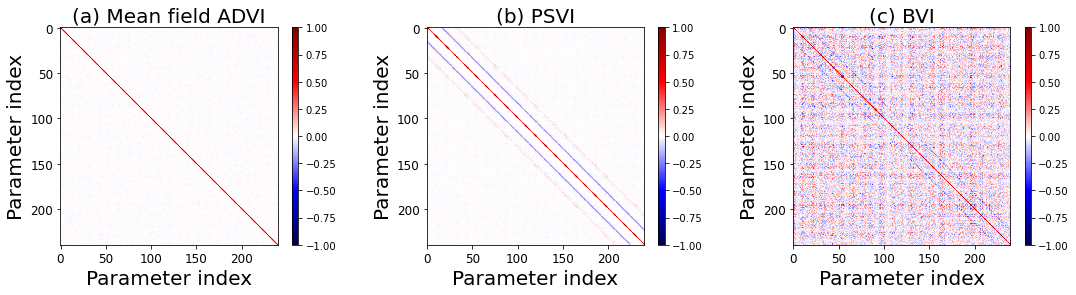

In [66]:
nrow = 1
ncol = 3

covariance = [cov_advi_small, cov_psvi_small, cov_bvi_small]
title = ['(a) Mean field ADVI', '(b) PSVI', '(c) BVI']
clim = [(-1, 1)]

fig, ax = plt.subplots(nrows = nrow, ncols = ncol, figsize = (18, 4))

for j in range(ncol):
    for i in range(nrow):
        k = i * ncol + j
        cov = covariance[k]
        im = ax[j].imshow(cov, cmap = 'seismic', clim = clim[0])
        ax[j].set_title(title[k], fontsize = 20)
        ax[j].set_ylabel('Parameter index', fontsize=20)
        ax[j].tick_params(axis="y", labelsize=12)
        ax[j].tick_params(axis="x", labelsize=12)
        ax[j].set_xlabel('Parameter index', fontsize=20)
        
        divider = make_axes_locatable(ax[j])
        cax = divider.append_axes("right",size="3%",pad=0.2)
        cbar = plt.colorbar(im, cax = cax)
        
fig.subplots_adjust(wspace=0.35,hspace=0.35)
plt.show()

# References

1. Xuebin Zhao and Andrew Curtis, 2024a. Bayesian Inversion, Uncertainty Analysis and Interrogation using Boosting Variational Inference. J. Geophys. Res. Solid Earth.
2. Xuebin Zhao and Andrew Curtis, 2024b. Physically Structured Variational Inference for Bayesian Full Waveform Inversion. ESS Open archive.
3. Xuebin Zhao and Andrew Curtis, 2024c. Variational Prior Replacement in Bayesian Inference and Inversion. arXiv.